In [19]:
import pandas as pd
import numpy as np
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import FastText
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
fasttext = FastText("simple")

In [4]:
def load_data(path):
    df = pd.read_csv(path, header=None, nrows=3000, skiprows=1, usecols=[1,2,3])
    df.rename({1: 'star', 2: 'rating1', 3: 'rating2'}, axis=1, inplace=True)
    df['review'] = df['rating1'] + ' ' + df['rating2']
    df.drop(columns=['rating1', 'rating2'], inplace=True)
    return df

In [5]:
def train_test_split(df, train_size=0.8):
    df_idx = [i for i in range(len(df))]
    np.random.shuffle(df_idx)
    len_train = int(len(df) * train_size)
    df_train = df.iloc[:len_train].reset_index(drop=True)
    df_test = df.iloc[len_train:].reset_index(drop=True)
    return df_train, df_test

In [6]:
def preprocessing(sentence):
    """
    Get rid of special symbols, lower case the words.
    return token list
    """
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
    return tokens

In [7]:
def token_encoder(token, vec):
    if token == "<pad>":
        return 1
    else:
        try:
            return vec.stoi[token]
        except:
            return 0

In [8]:
def encoder(tokens, vec):
    return [token_encoder(token, vec) for token in tokens]

In [9]:
def padding(list_of_idx, max_seq_len, padding_index=1):
    output = list_of_idx + (max_seq_len - len(list_of_idx))*[padding_index]
    return output[:max_seq_len]

In [10]:
class DataClass(Dataset):
    def __init__(self, df, max_seq_len=32):
        self.max_seq_len = max_seq_len
        train_iter = iter(df.review.values)
        self.vec = FastText("simple")
        self.vec.vectors[1] = -torch.ones(self.vec.vectors[1].shape[0])
        self.vec.vectors[0] = torch.zeros(self.vec.vectors[0].shape[0])
        self.vectorizer = lambda x: self.vec.vectors[x]
        self.labels = df.star
        sequences = [padding(encoder(preprocessing(sequence), self.vec), max_seq_len) for sequence in df.review.tolist()]
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]

In [11]:
BATCH_SIZE = 32
df = load_data('/Users/szokirov/Documents/GitHub/strive_practice/Chapter 03/18. Semantic Analysis/.data/Amazon/3000test.csv')
df.star = df.star.apply(lambda x: int(x) -1)

train_df, test_df = train_test_split(df)
train_df, test_df = DataClass(train_df), DataClass(test_df)
df.star.unique()

array([0, 3, 1, 2, 4])

In [12]:
df.star.unique()

array([0, 3, 1, 2, 4])

In [13]:
def collate_train(batch, vectorizer=train_df.vectorizer):
    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

def collate_test(batch, vectorizer=test_df.vectorizer):
    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

In [14]:
train_loader = DataLoader(train_df, batch_size=BATCH_SIZE, collate_fn=collate_train, shuffle=True)
test_loader = DataLoader(test_df, batch_size=BATCH_SIZE, collate_fn=collate_test)

In [15]:
from torch import nn
import torch.nn.functional as F
emb_dim = 300
class Classifier(nn.Module):
    def __init__(self, max_seq_len, emb_dim, hidden1=16, hidden2=16):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(max_seq_len*emb_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 5)
        self.out = nn.LogSoftmax(dim=1)
    
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.out(x)

In [16]:
MAX_SEQ_LEN = 32
model = Classifier(MAX_SEQ_LEN, 300, 16, 16)
model

Classifier(
  (fc1): Linear(in_features=9600, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=5, bias=True)
  (out): LogSoftmax(dim=1)
)

In [17]:
from torch import optim
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=0.003)

Epoch: 1/300, Train loss: 0.5278, Test loss: 5.1843, Accuracy: 0.2341
Epoch: 2/300, Train loss: 0.5298, Test loss: 5.4449, Accuracy: 0.2473
Epoch: 3/300, Train loss: 0.5250, Test loss: 5.3440, Accuracy: 0.2467
Epoch: 4/300, Train loss: 0.5107, Test loss: 5.5062, Accuracy: 0.2346
Epoch: 5/300, Train loss: 0.5430, Test loss: 5.4186, Accuracy: 0.2396
Epoch: 6/300, Train loss: 0.5154, Test loss: 5.6593, Accuracy: 0.2346
Epoch: 7/300, Train loss: 0.5069, Test loss: 5.6326, Accuracy: 0.2396
Epoch: 8/300, Train loss: 0.5409, Test loss: 5.4605, Accuracy: 0.2292
Epoch: 9/300, Train loss: 0.5114, Test loss: 5.4704, Accuracy: 0.2412
Epoch: 10/300, Train loss: 0.4963, Test loss: 5.8247, Accuracy: 0.2292
Epoch: 11/300, Train loss: 0.5074, Test loss: 5.6471, Accuracy: 0.2462
Epoch: 12/300, Train loss: 0.4953, Test loss: 5.9152, Accuracy: 0.2478
Epoch: 13/300, Train loss: 0.5002, Test loss: 6.0744, Accuracy: 0.2045
Epoch: 14/300, Train loss: 0.4998, Test loss: 6.1178, Accuracy: 0.2363
Epoch: 15/300, 

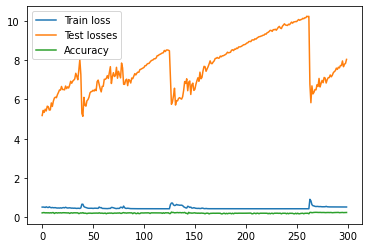

In [21]:
epochs = 300
print_every = 40
train_losses, test_losses, accuracies = [], [], []

for e in range(epochs):
    running_loss, running_test_losses, running_test_accuracy = 0, 0, 0
    # print(f"Epoch: {e+1}/{epochs}")

    for i, (sentences, labels) in enumerate(iter(train_loader)):

        sentences.resize_(sentences.size()[0], 32* emb_dim)
        
        optimizer.zero_grad()
        
        output = model.forward(sentences)   # 1) Forward pass
        train_loss = criterion(output, labels) # 2) Compute loss
        train_loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += train_loss.item()
        
        # if i % print_every == 0:
        #     print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
        #     running_loss = 0
    avg_running_loss = running_loss/len(train_loader)
    train_losses.append(avg_running_loss)

    model.eval()
    with torch.no_grad():
        for i, (sentences_test, labels_test) in enumerate(iter(test_loader)):
            sentences_test.resize_(sentences_test.size()[0], 32* emb_dim)

            output_test = model.forward(sentences_test)
            test_loss = criterion(output_test, labels_test)

            running_test_losses += test_loss.item()

            prediction_label = torch.argmax(output_test, dim=1)
            running_test_accuracy += (prediction_label == labels_test).sum() / len(labels_test)
        avg_test_loss = running_test_losses/len(test_loader)
        test_losses.append(avg_test_loss)
        avg_running_accuracy = running_test_accuracy/len(test_loader)
        accuracies.append(avg_running_accuracy)

    model.train()

    print(f"Epoch: {e+1}/{epochs}, Train loss: {avg_running_loss:.4f}, Test loss: {avg_test_loss:.4f}, Accuracy: {avg_running_accuracy:.4f}" )

torch.save({'model_state': model.state_dict()}, 'final_model')
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test losses')
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.show()

            

        